# Exploration of electricity and weather data 

#### Key points
1. Trend through time (month, day, day)
2. Minimum and maximum of consumption per time frame
3. Correlations between variables:
      - Consumption vs. time of year
      - Consumptions vs. weather 

## 1. Trend analysis - date and time

In [91]:
# Import libraries for plotting, reading and wrangling data
library(ggplot2)
library(cowplot)
library(gridExtra)
library(readr) 
library(dplyr)
library(tibble)
library(grid)
source("Scripts/Common/func.R")

### Read Data Frames

In [92]:
# Read hourly, daily and monthly electricity consumption data in csv files
ConsHourDF  <- read_csv("curated/electricity/gold_hourly_electricity.csv",     show_col_types = FALSE)
ConsDayDF   <- read_csv("curated/electricity/gold_daily_electricity.csv",      show_col_types = FALSE)
ConsMonthDF <- read_csv("curated/electricity/gold_monthly_electricity.csv",    show_col_types = FALSE)

### Global Variables

In [120]:
#==============================================
# HOUR
#==============================================
# Define average, minimal and maximal thresholds
avg_hour_consumption    <- mean(ConsHourDF$consumption)
pct05_hour_consumption  <- quantile(ConsHourDF$consumption, 0.05)
pct95_hour_consumption  <- quantile(ConsHourDF$consumption, 0.95)
# Define outliers columns: either below or above thresholds
ConsHourDF <- ConsHourDF %>% mutate(is_outlier = (consumption < pct05_hour_consumption) | (consumption > pct95_hour_consumption))

#==============================================
# DAY
#==============================================
# Define average, minimal and maximal thresholds
avg_day_consumption    <- mean(ConsDayDF$consumption)
pct05_day_consumption  <- quantile(ConsDayDF$consumption, 0.05)
pct95_day_consumption  <- quantile(ConsDayDF$consumption, 0.95)
# Define outliers columns: either below or above thresholds
ConsDayDF <- ConsDayDF %>% mutate(is_outlier = (consumption < pct05_day_consumption) | (consumption > pct95_day_consumption))

#==============================================
# MONTH
#==============================================
# Define average, minimal and maximal thresholds
avg_month_consumption    <- mean(ConsMonthDF$consumption)
pct05_month_consumption  <- quantile(ConsMonthDF$consumption, 0.05)
pct95_month_consumption  <- quantile(ConsMonthDF$consumption, 0.95)
# Define outliers columns: either below or above thresholds
ConsMonthDF <- ConsMonthDF %>% mutate(
        is_outlier = (consumption < pct05_month_consumption) | (consumption > pct95_month_consumption),
        month_str = ifelse(nchar(month) == 1, paste0("0", as.character(month)), as.character(month)),
        year_month = factor(paste(year, month_str, sep = "-"))
    ) %>%
    select(-month_str)

### a) Daily and hourly consumption

#### Plot 1: Line plot - Four weeks comparison

##### Prepare Data Frames for line plot

In [94]:
# Date parameters
# The year and month have been selected randomly
year <- 2013
month <- 01

# Calculate four weeks dataframes
ConsDayHourWeekOneDF    <- ConsHourDF %>% filter_date_range(year, month, 0, 7)      %>% create_instant_time()
ConsDayHourWeekTwoDF    <- ConsHourDF %>% filter_date_range(year, month, 7, 14)     %>% create_instant_time()
ConsDayHourWeekThreeDF  <- ConsHourDF %>% filter_date_range(year, month, 14, 21)    %>% create_instant_time()
ConsDayHourWeekFourDF   <- ConsHourDF %>% filter_date_range(year, month, 21, 28)    %>% create_instant_time()

##### Plot data

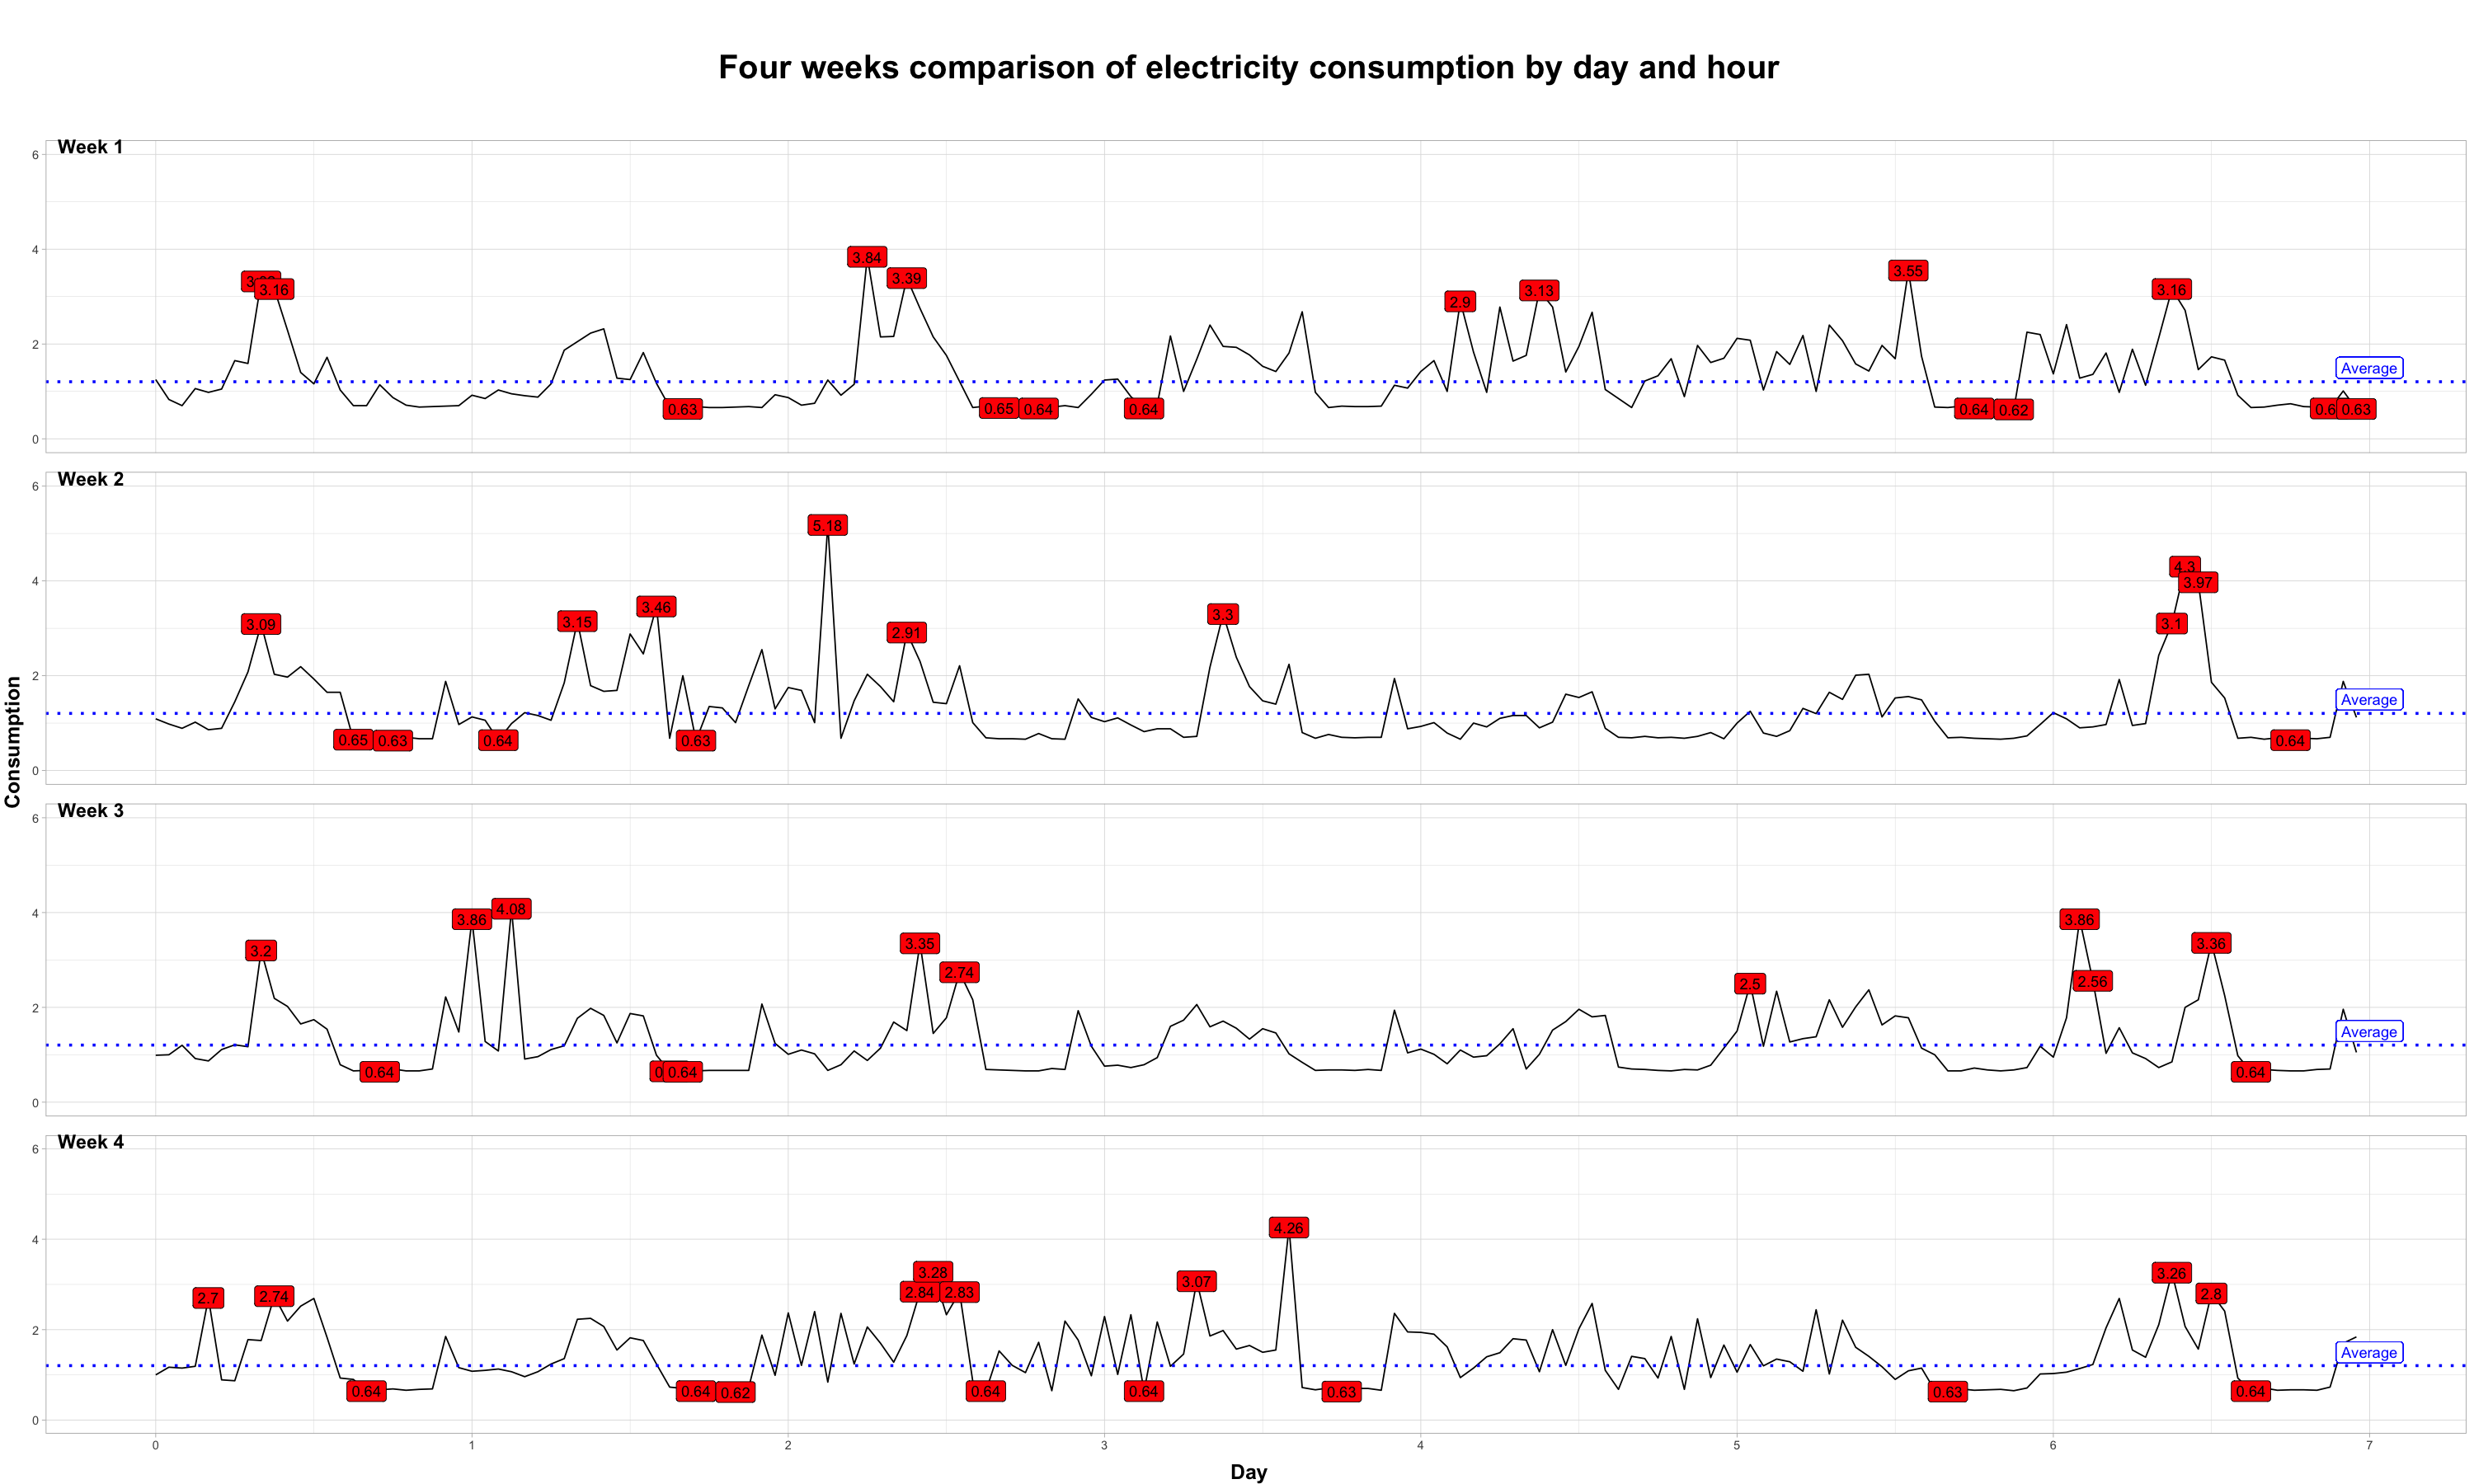

In [95]:
# Visualization of electricity consumption per day and hour
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 15)
# Plot labels definition
label_properties_list <- list("pct05_color"="black", "pct95_color"="black", "pct05_fill"="red", "pct95_fill"="red")
# Plot definitions
plt_wk1 <- create_base_weekly_line_plot(ConsDayHourWeekOneDF,   instant, consumption, label_properties_list, avg_hour_consumption, 0, 6)
plt_wk2 <- create_base_weekly_line_plot(ConsDayHourWeekTwoDF,   instant, consumption, label_properties_list, avg_hour_consumption, 0, 6)
plt_wk3 <- create_base_weekly_line_plot(ConsDayHourWeekThreeDF, instant, consumption, label_properties_list, avg_hour_consumption, 0, 6)
plt_wk4 <- create_base_weekly_line_plot(ConsDayHourWeekFourDF,  instant, consumption, label_properties_list, avg_hour_consumption, 0, 6, TRUE)

# Grid of plots definition
global_grid <- plot_grid(
    plt_wk1, plt_wk2, plt_wk3, plt_wk4,
    labels = c("Week 1", "Week 2", "Week 3", "Week 4"), label_y = 1,
    ncol = 1, nrow = 4
)

# Titles definition
title       <- ggdraw() + draw_label("Four weeks comparison of electricity consumption by day and hour", fontface = "bold", size = 24)
x_title     <- textGrob("Day", gp = gpar(fontface="bold", col="black", fontsize = 15))
y_title     <- textGrob("Consumption", gp = gpar(fontface="bold", col="black", fontsize = 15), rot=90)
plot        <- plot_grid(title, global_grid, ncol = 1, rel_heights = c(0.1, 1))

# Arrange the plot to have global x and y titles
grid.arrange(arrangeGrob(plot, bottom = x_title, left = y_title))

### b) Hourly consumption

#### Base plot and configuration

In [96]:
# Define basic plot
base_plt_hour           <- ggplot(ConsHourDF, aes(x = hour, y = consumption))
# Define horizontal plot for average consumption
base_hline_avg_hour     <- geom_hline(yintercept = avg_hour_consumption, color = "blue", linetype = "dotted", linewidth = 1)
# Define horizontal plot for consumption at the 95th percentile
base_hline_pct95_hour   <- geom_hline(yintercept = pct95_hour_consumption, color = "red", linetype = "dotted", linewidth = 1)
# Define plot title
base_title_hour         <- ggtitle("Distribution of electricity consumption by hour")
# Define plot theme
base_theme_hour         <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )
# Define filtered Data Frame for the plot labels
maxConsHourDF <- ConsHourDF %>% group_by(hour) %>% summarise(consumption = max(consumption))


#### Plot 2: Scatter plot with jitter - Consumption by hour

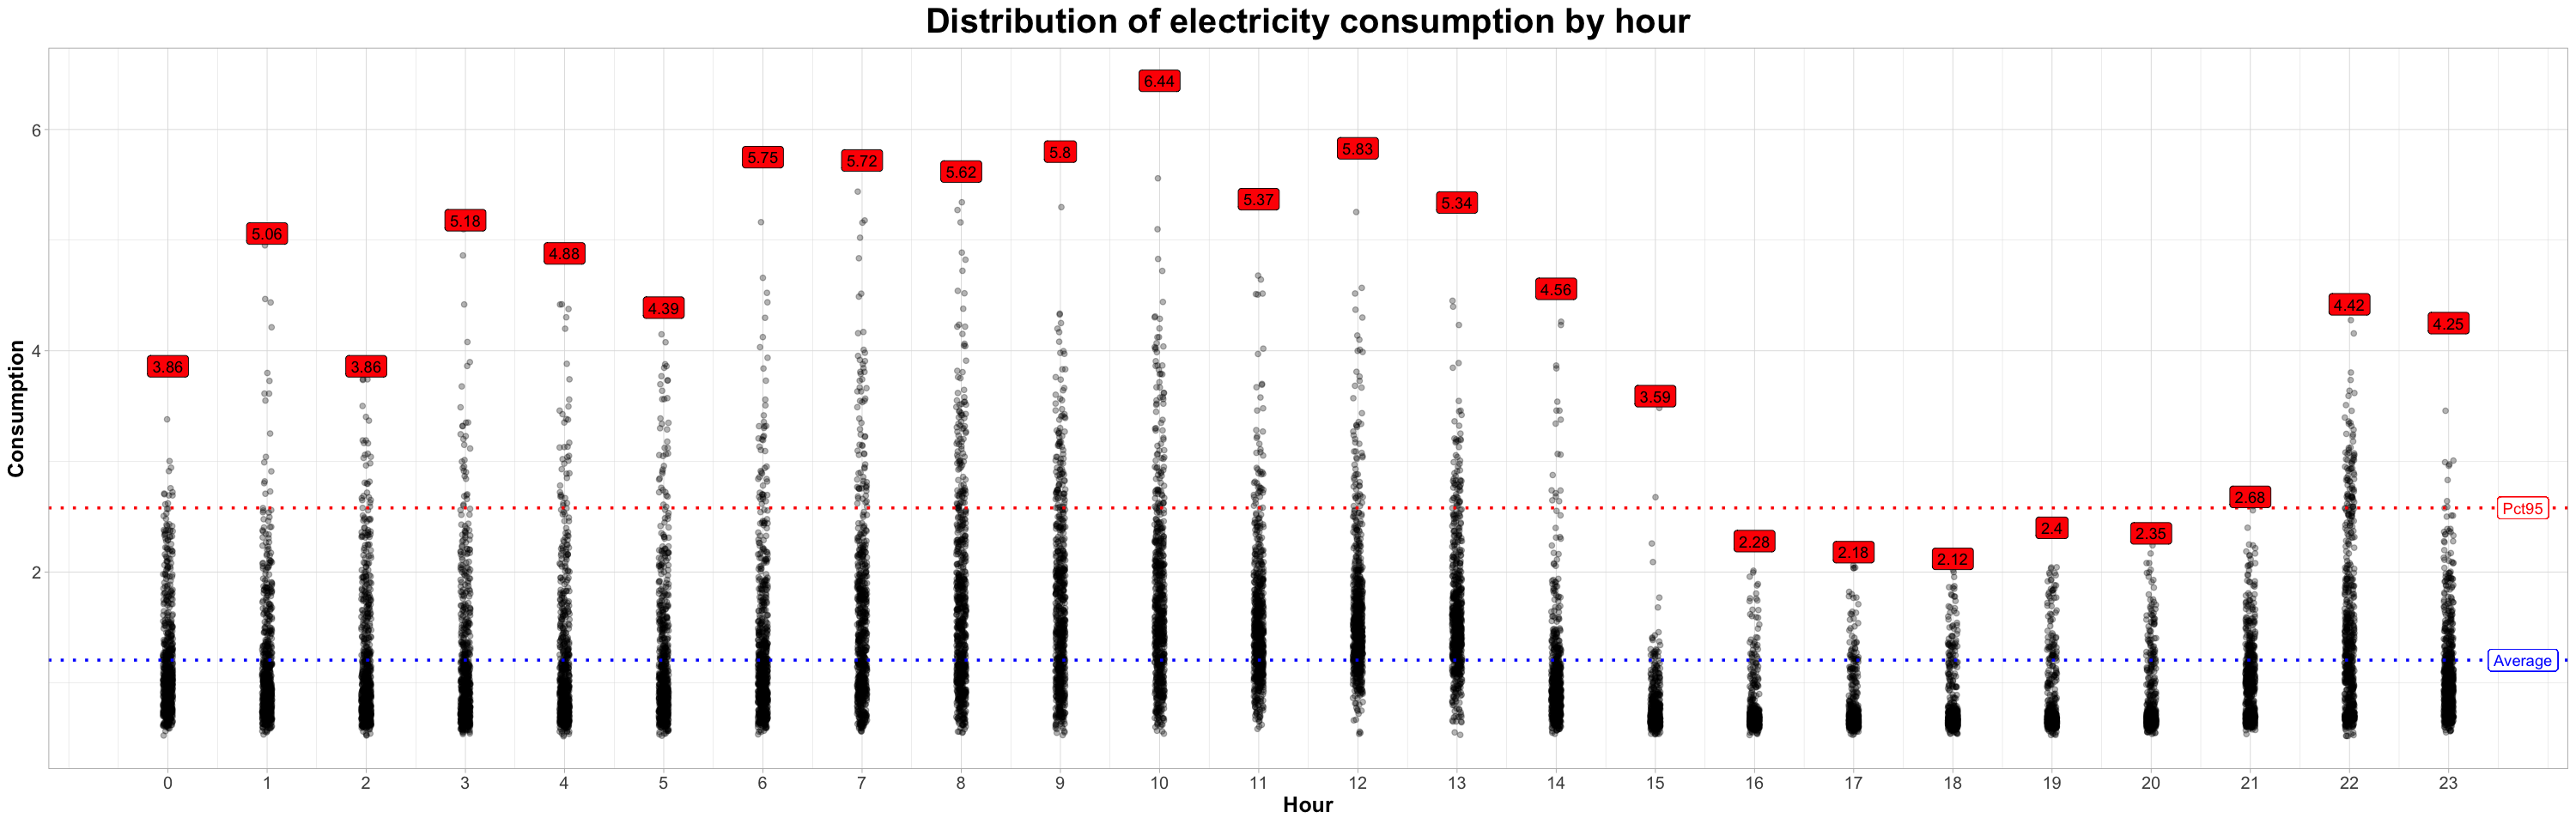

In [97]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define scatter plot
base_plt_hour + 
    geom_jitter(alpha = 0.3, width = 0.05) + 
    scale_x_continuous(breaks = 0:23, labels = 0:23) +
    base_hline_avg_hour +
    base_hline_pct95_hour +
    geom_label(label = "Average", x = 23.75, y = avg_hour_consumption, color = "blue") +
    geom_label(label = "Pct95", x = 23.75, y = pct95_hour_consumption, color = "red") +
    geom_label(data = maxConsHourDF, aes(label = consumption), color = "black", fill = "red") +
    labs(x = "Hour", y = "Consumption") +
    base_title_hour +
    base_theme_hour

#### Plot 3: Boxplot - Distribution of consumption by hour

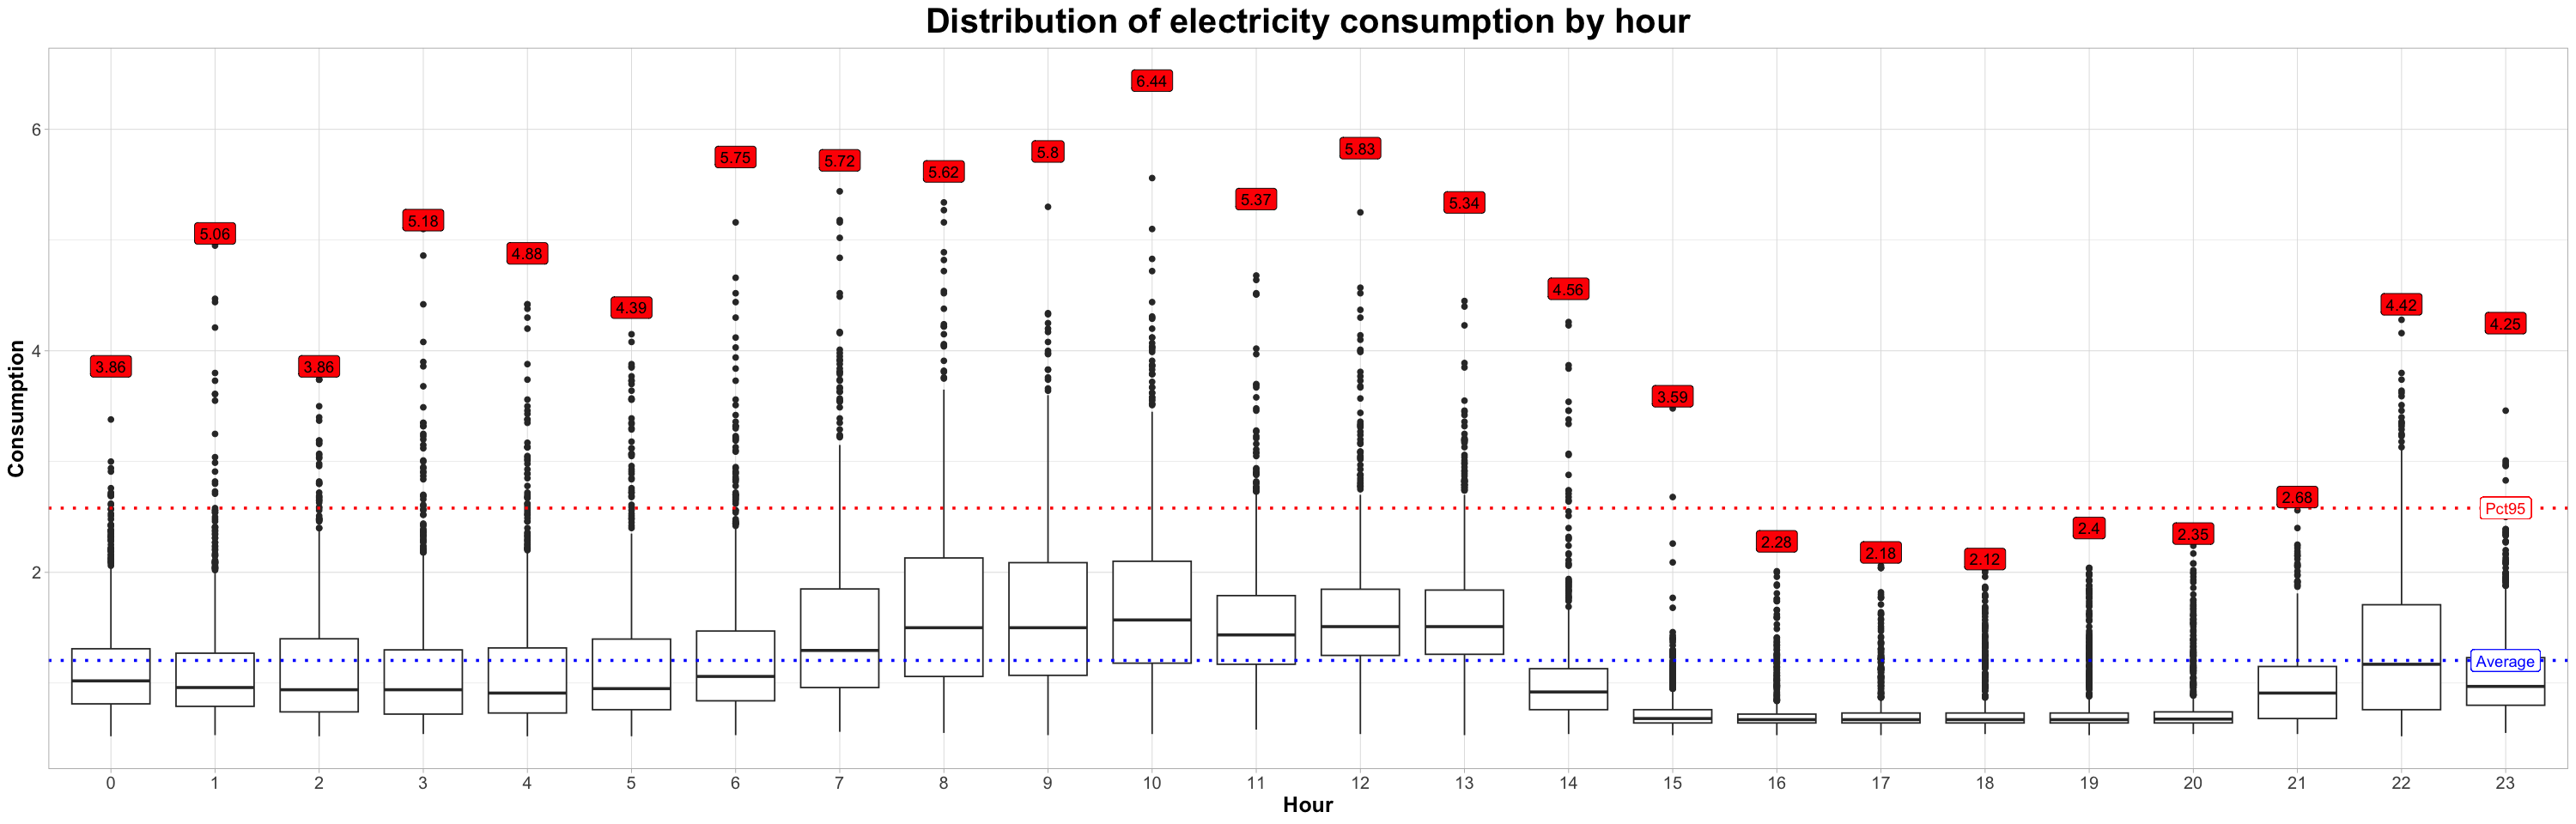

In [98]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define box plot
base_plt_hour + 
    geom_boxplot(aes(x = factor(hour))) + 
    base_hline_avg_hour +
    base_hline_pct95_hour +
    geom_label(label = "Average", x = 24, y = avg_hour_consumption, color = "blue") +
    geom_label(label = "Pct95", x = 24, y = pct95_hour_consumption, color = "red") +
    geom_label(data = maxConsHourDF, aes(label = consumption), nudge_x = 1, color = "black", fill = "red") +
    labs(x = "Hour", y = "Consumption") +
    base_title_hour +
    base_theme_hour

### c) Daily consumption

#### Base plot and configuration

In [103]:
# Define basic plot
base_plt_day           <- ggplot(ConsDayDF, aes(x = day, y = consumption))
# Define horizontal plot for average consumption
base_hline_avg_day     <- geom_hline(yintercept = avg_day_consumption, color = "blue", linetype = "dotted", linewidth = 1)
# Define horizontal plot for consumption at the 95th percentile
base_hline_pct95_day   <- geom_hline(yintercept = pct95_day_consumption, color = "red", linetype = "dotted", linewidth = 1)
# Define plot title
base_title_day         <- ggtitle("Distribution of electricity consumption by day")
# Define plot theme
base_theme_day         <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )
# Define filtered Data Frame for the plot labels
maxConsDayDF <- ConsDayDF %>% group_by(day) %>% summarise(consumption = max(consumption))

#### Plot 4: Boxplot - Distribution of consumption by day number

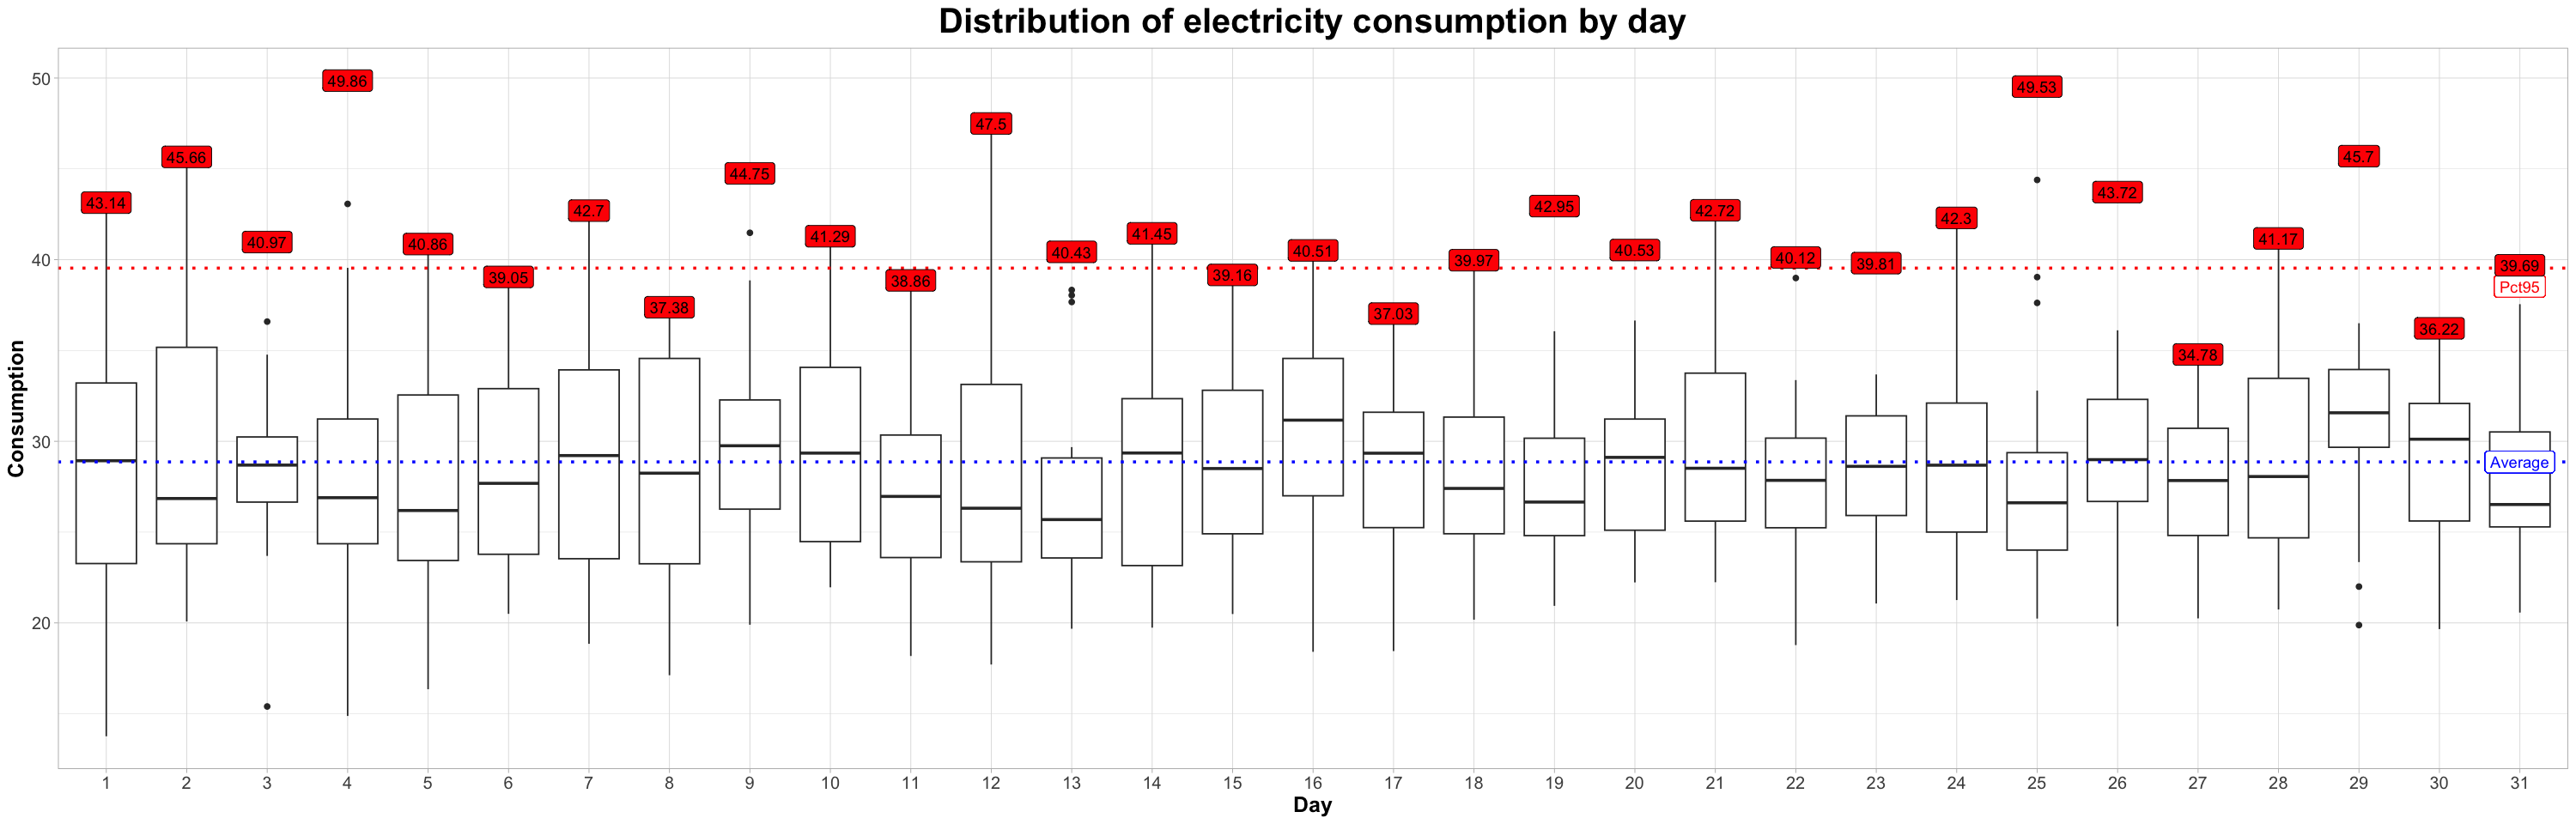

In [104]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_day +
    geom_boxplot(aes(x = factor(day))) +
    base_hline_avg_day +
    base_hline_pct95_day +
    geom_label(label = "Average", x = 31, y = avg_day_consumption, color = "blue", show.legend = TRUE) +
    geom_label(label = "Pct95", x = 31, y = pct95_day_consumption - 1, color = "red") +
    geom_label(data = maxConsDayDF, aes(label = consumption), color = "black", fill = "red") +
    base_labels_day +
    base_title_day + 
    base_theme_day

#### Plot 5: Line plot - Consumption by day number

In [110]:
# Aggregate data by day number
ConsDayNumDF <- ConsDayDF %>%
    group_by(day) %>%
    summarize(
        consumption = mean(consumption)
    )

pct95_day_num_consumption <- quantile(ConsDayNumDF$consumption, 0.95)
# Threshold: 95%
ConsDayNumDF <- ConsDayNumDF %>% mutate(is_outlier = consumption > pct95_day_num_consumption)

In [112]:
# Define basic plot
base_plt_day           <- ggplot(ConsDayNumDF, aes(x = day, y = consumption))
# Define horizontal plot for average consumption
base_hline_avg_day     <- geom_hline(yintercept = avg_day_consumption, color = "blue", linetype = "dotted", linewidth = 1)
# Define horizontal plot for consumption at the 95th percentile
base_hline_pct95_day   <- geom_hline(yintercept = pct95_day_num_consumption, color = "red", linetype = "dotted", linewidth = 1)
# Define plot title
base_title_day         <- ggtitle("Average electricity consumption by day")
# Define plot theme
base_theme_day         <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


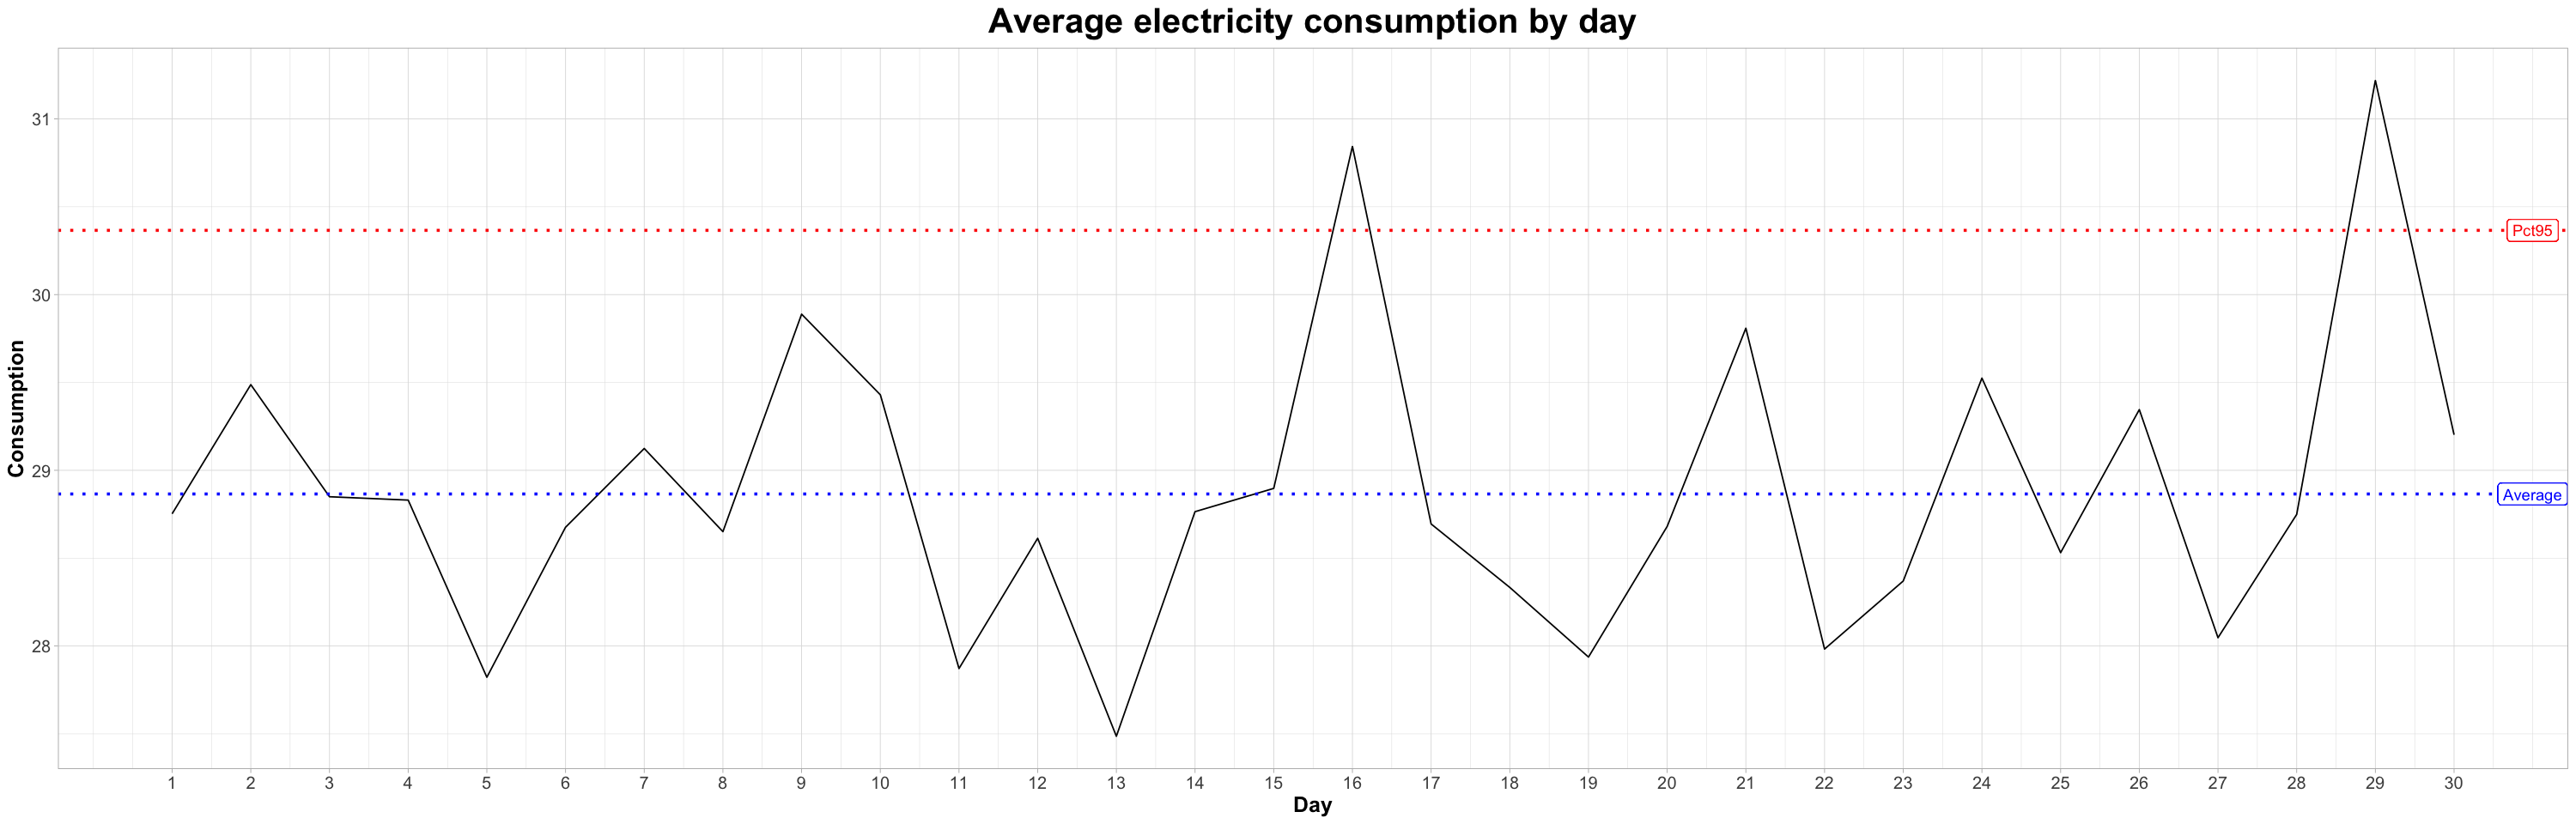

In [118]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_day +
    geom_line() +
    base_hline_avg_day +
    base_hline_pct95_day +
    scale_x_continuous(breaks = 1:30, labels = 1:30, limits = c(1, 30)) +
    geom_label(label = "Average", x = 31, y = avg_day_consumption, color = "blue", show.legend = TRUE) +
    geom_label(label = "Pct95", x = 31, y = pct95_day_num_consumption, color = "red") +
    base_labels_day +
    base_title_day + 
    base_theme_day

### d) Monthly consumption

#### Base plot and configuration

In [123]:
# Define basic plot
base_plt_month         <- ggplot(ConsMonthDF, aes(x = month, y = consumption))
# Define horizontal plot for average consumption
base_hline_avg_month     <- geom_hline(yintercept = avg_month_consumption, color = "blue", linetype = "dotted", linewidth = 1)
# Define horizontal plot for consumption at the 95th percentile
base_hline_pct95_month   <- geom_hline(yintercept = pct95_month_consumption, color = "red", linetype = "dotted", linewidth = 1)
# Define plot title
base_title_month         <- ggtitle("Distribution of electricity consumption by month")
# Define plot theme
base_theme_month         <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )
# Define filtered Data Frame for the plot labels
maxConsMonthDF <- ConsMonthDF %>% group_by(month) %>% summarise(consumption = max(consumption))

#### Plot 6: Boxplot - Consumption by month

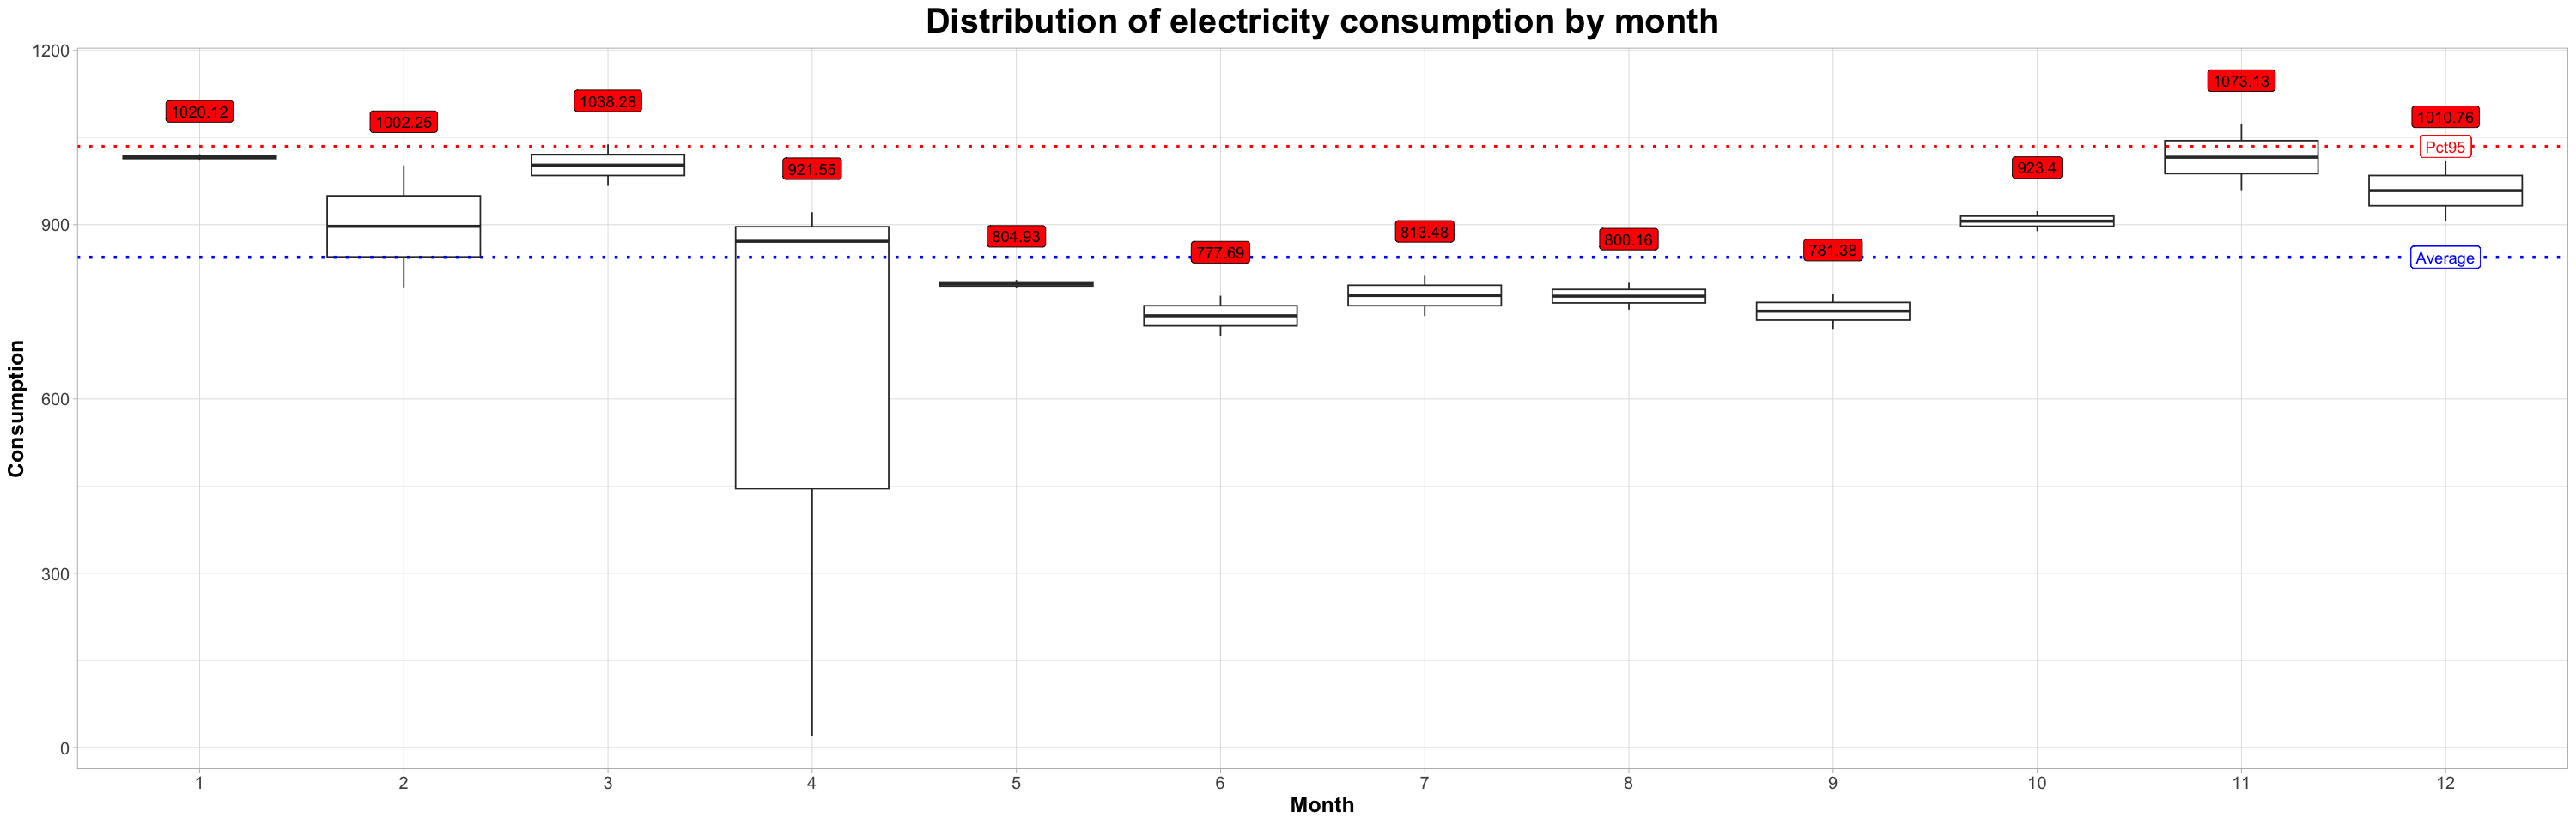

In [125]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_month +
    geom_boxplot(aes(x = factor(month))) +
    base_hline_avg_month +
    base_hline_pct95_month +
    geom_label(label = "Average", x = 12, y = avg_month_consumption, color = "blue") +
    geom_label(label = "Pct95", x = 12, y = pct95_month_consumption, color = "red") +
    geom_label(data = maxConsMonthDF, aes(label = consumption), nudge_y = 75, color = "black", fill = "red") +
    labs(x = "Month", y = "Consumption") +
    base_title_month + 
    base_theme_month

#### Plot 8: Line plot - Consumption by year and month

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


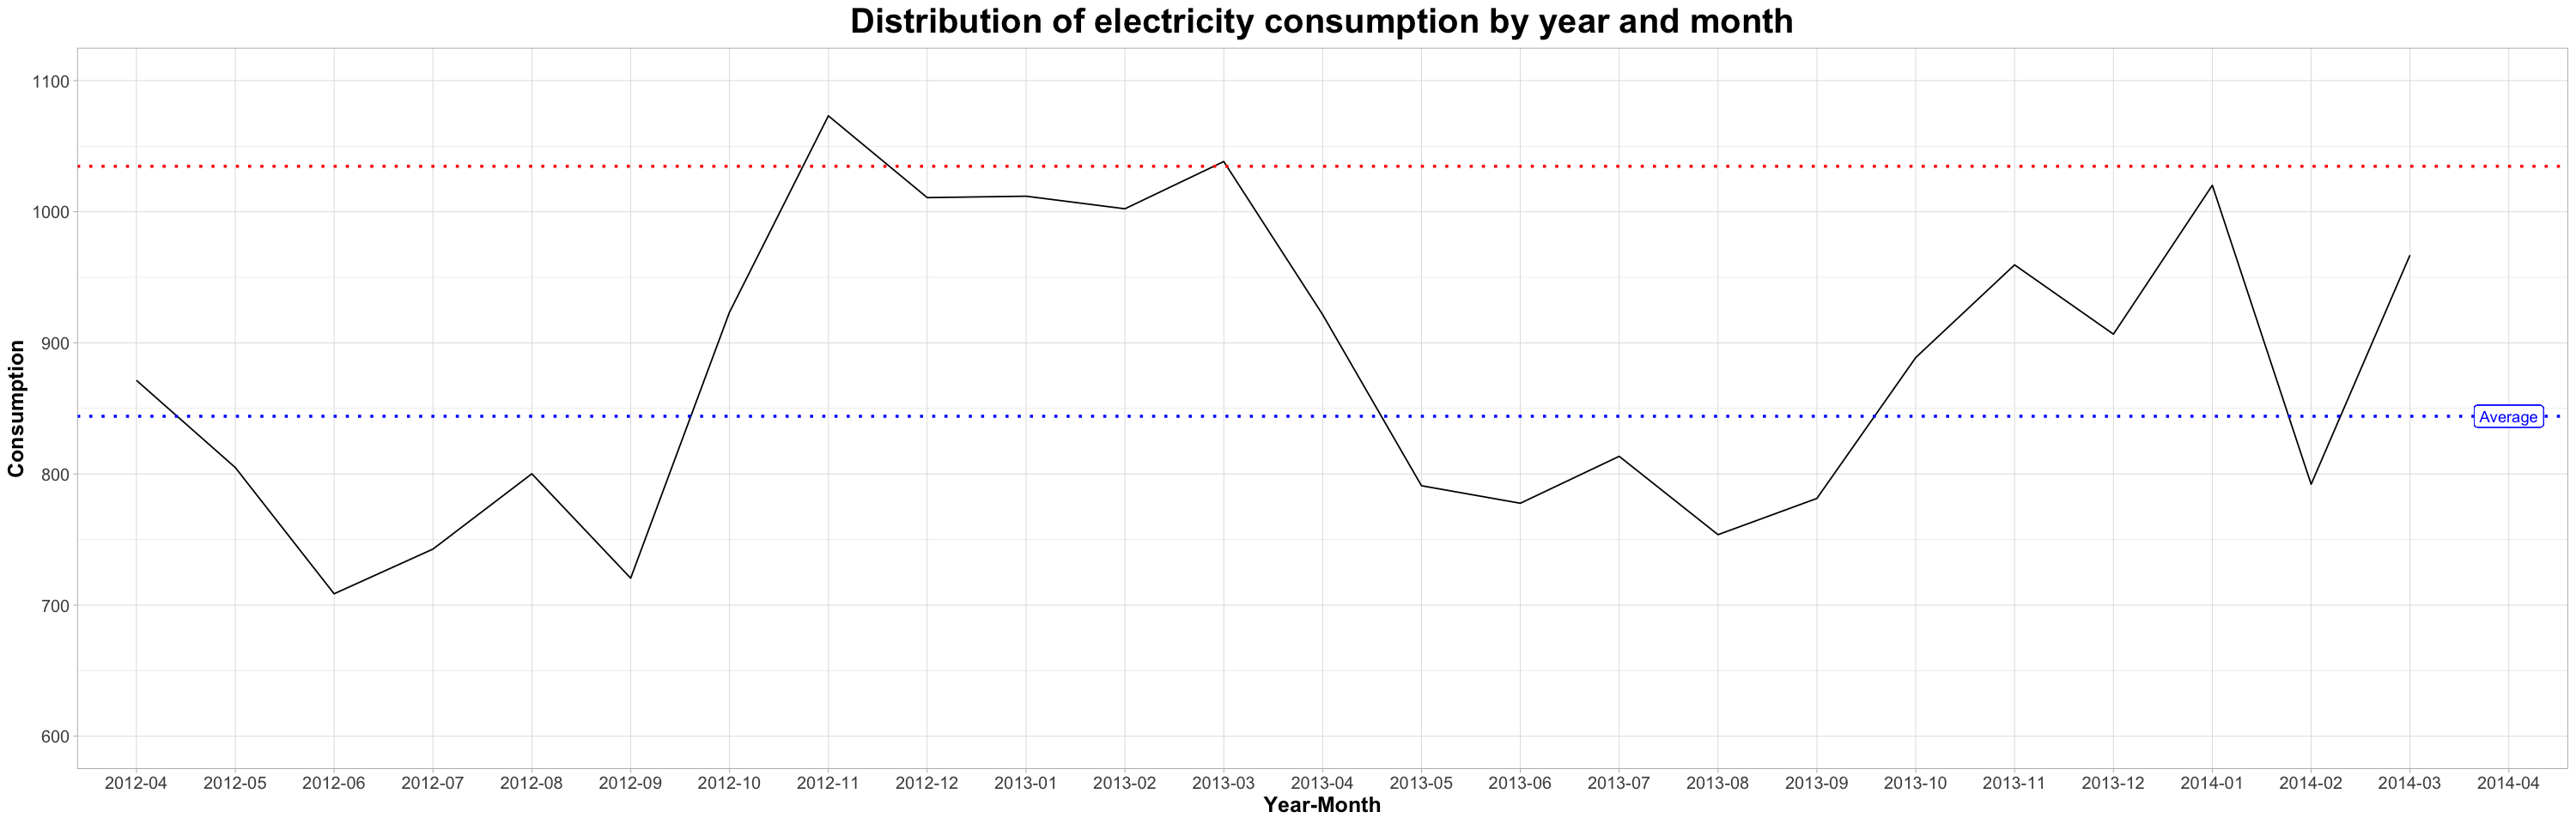

In [129]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define line plot
base_plt_month +
    geom_line(aes(x = factor(year_month), group = 1)) +
    base_hline_avg_month +
    base_hline_pct95_month +
    ylim(c(600, 1100)) +
    geom_label(label = "Average", x = "2014-04", y = avg_month_consumption, color = "blue", show.legend = TRUE) +
    labs(x = "Year-Month", y = "Consumption") +
    ggtitle("Distribution of electricity consumption by year and month") + 
    base_theme_month